![amazon_logo](banner.png)
___

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#from scipy import stats
%matplotlib inline 
sns.set(color_codes=True)

#bag of words model
from sklearn.feature_extraction.text import CountVectorizer

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

#cross-validation
from sklearn.model_selection import cross_val_score

#classification 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

#classifier evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# Step 4a - Classification - Intitial Findings
    a) Importing Data
    
    b) Split into Train/Test
   
    c) Resampling
        i) Random Oversampling
       ii) Random Undersampling  
       
    d) Classification
        i) Over-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM
       ii) Under-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM

## a) Importing data

In [2]:
#import amazon_cleaned2_data.csv file
cleaned2_df = pd.read_csv("amazon_cleaned2_data.csv")

cleaned2_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(cleaned2_df.shape)

(159367, 10)


In [3]:
#import corpus_data.csv file
corpus_df = pd.read_csv("amazon_corpus_data.csv")

corpus_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(corpus_df.shape)
corpus_df.head()

(100000, 1)


,review
0,awesine perfect new parent able keep track bab...
1,required new parent book life saver helpful ab...
2,grandmother watching baby help know exactly ba...
3,repeat buyer bought time older son bought newb...
4,great wanted alternative printing daily log sh...


In [4]:
#append corpus review to cleaned2_df
cleaned2_df['review_corpus'] = corpus_df['review']
cleaned2_df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,total_review,state,review_corpus
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5,Awesine,2013-07-16,Awesine Perfect for new parents. We were able ...,Good,awesine perfect new parent able keep track bab...


##### Since we only used the first 100,000 reviews in our NLP step (for performance reasons) our dataset is only 99998 reviews long now after we remove all the NaN's

In [5]:
#locate NaN
is_NaN = cleaned2_df.isna()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = cleaned2_df[row_has_NaN]
#remove NaN
cleaned2_df = cleaned2_df.dropna()
print(cleaned2_df.isna().sum())
print(cleaned2_df.shape)

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
total_review      0
state             0
review_corpus     0
dtype: int64
(99998, 11)


## b) Split into Train/Test

In [6]:
msk = np.random.rand(len(cleaned2_df)) < 0.75

train_df = cleaned2_df[msk]
test_df = cleaned2_df[~msk]

In [7]:
print(len(test_df))
print(len(train_df))

24980
75018


In [8]:
#split test into X_test and y_test for later
y_test = test_df['state']
X_test = test_df.drop('state',axis=1)

## c) Resampling

In [9]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(train_df['state'].unique())
train_df.state.replace(['Good', 'Bad'], [1, 0], inplace=True)
print(train_df['state'].unique())

['Good' 'Bad']
[1 0]


C:\Users\vlad_\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [10]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(test_df['state'].unique())
test_df.state.replace(['Good', 'Bad'], [1, 0], inplace=True)
print(test_df['state'].unique())

['Good' 'Bad']
[1 0]


In [11]:
train_df['state'].value_counts()

1    43590
0    31428
Name: state, dtype: int64

In [12]:
#class count
count_class_1, count_class_0 = train_df.state.value_counts()

#divide by class
df_class_0 = train_df[train_df['state'] == 0]
df_class_1 = train_df[train_df['state'] == 1]

##### i) Random Over-Sampling

Random over-sampling:
1    43590
0    43590
Name: state, dtype: int64


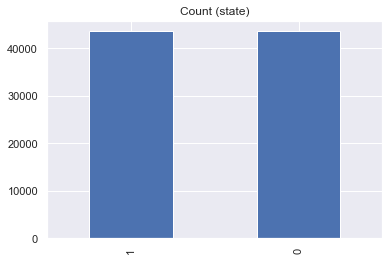

In [13]:
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over.state.value_counts())

df_test_over.state.value_counts().plot(kind='bar', title='Count (state)')

##### ii) Random under-sampling

Random under-sampling:
1    31428
0    31428
Name: state, dtype: int64


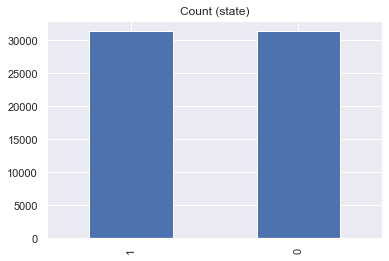

In [14]:
df_class_1_under = df_class_1.sample(count_class_0)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
df_test_under['state'].value_counts()
print('Random under-sampling:')
print(df_test_under.state.value_counts())

df_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

## d) Classification

The following lines will include classification algorithms using 3 types of data: the original data with outliers removed, oversampled data, and undersampled data.

### i) Oversampled Data


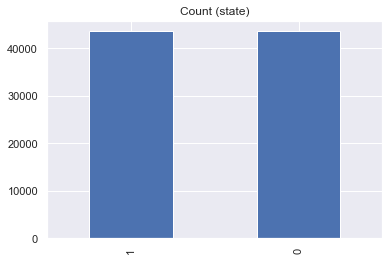

In [15]:
df2_test_over = pd.DataFrame(df_test_over)
df2_test_over.state.value_counts().plot(kind='bar', title='Count (state)');

In [16]:
#split into X_train and y_train
X_over_train = df2_test_over.drop('state',axis=1)
y_over_train = df2_test_over['state']

In [17]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_over_train['review_corpus'])
X_vec_train.shape

(87180, 1095501)

In [18]:
#apply TFIDF on train set
tfidf_transformer = TfidfTransformer()
train_over_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_over_tfidf.shape

(87180, 1095501)

In [19]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['review_corpus'])
X_vec_test.shape

(24980, 1095501)

In [20]:
#apply TFIDF on test set
test_over_tfidf = tfidf_transformer.transform(X_vec_test)
test_over_tfidf.shape

(24980, 1095501)

##### Naive Bayes Classifier

In [21]:
##fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = nb_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 7218  3208]
 [ 2027 12527]]


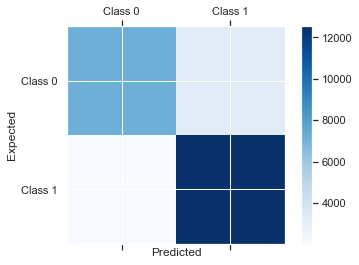

In [22]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [23]:
accText = 'Naive Bayes, Oversampling'

In [24]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 79.04%
 Precision: 79.61%
    Recall: 86.07%
  F1 score: 82.72%
 ROC score: 77.65%


In [25]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

##### Logistic Regression Classifier

In [26]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = reg_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 7367  3059]
 [ 2316 12238]]


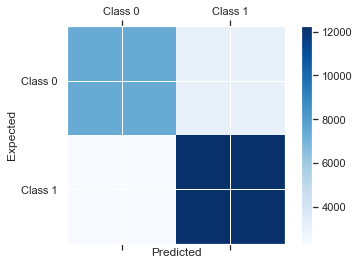

In [27]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [28]:
accText = 'Logistic Regression, Oversampling'

In [29]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 78.48%
 Precision: 80.00%
    Recall: 84.09%
  F1 score: 81.99%
 ROC score: 77.37%


In [30]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

##### KNN Classifier

In [31]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 15, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_over_tfidf, y_over_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 1


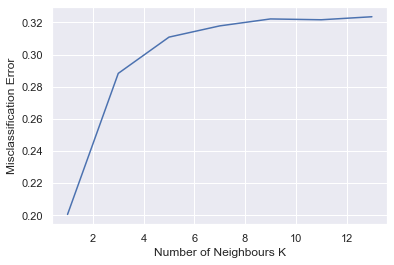

In [32]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [45]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 23, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = knn_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 5132  5294]
 [ 2185 12369]]


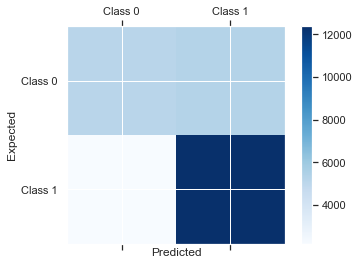

In [46]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [47]:
accText = 'KNN, Oversampling'

In [48]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 70.06%
 Precision: 70.03%
    Recall: 84.99%
  F1 score: 76.79%
 ROC score: 67.11%


In [49]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

##### SVM Classifier

In [50]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = svm_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 6627  3799]
 [ 2205 12349]]


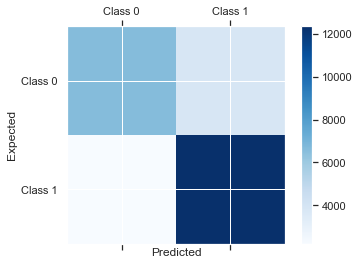

In [51]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [52]:
accText = 'SVM, Oversampling'

In [53]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 75.96%
 Precision: 76.47%
    Recall: 84.85%
  F1 score: 80.44%
 ROC score: 74.21%


In [54]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

### ii) Under-sampled data

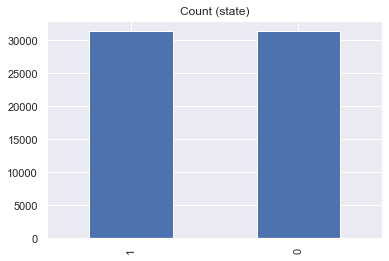

In [55]:
df2_test_under = pd.DataFrame(df_test_under)
df2_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

In [56]:
#split into X_train and y_train
X_under_train = df2_test_under.drop('state',axis=1)
y_under_train = df2_test_under['state']

In [57]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_under_train['review_corpus'])
X_vec_train.shape

(62856, 1081708)

In [58]:
#apply TFIDF on train set
tfidf_transformer = TfidfTransformer()
train_under_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_under_tfidf.shape

(62856, 1081708)

In [59]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['review_corpus'])
X_vec_test.shape

(24980, 1081708)

In [60]:
#apply TFIDF on test set
test_under_tfidf = tfidf_transformer.transform(X_vec_test)
test_under_tfidf.shape

(24980, 1081708)

##### Naive Bayes Classifier

In [61]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = nb_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 7585  2841]
 [ 2251 12303]]


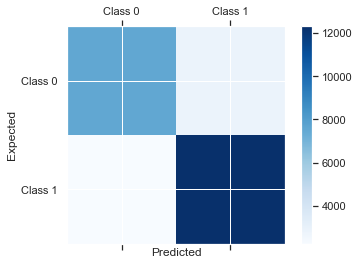

In [62]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [63]:
accText = 'Naive Bayes, Undersampling'

In [64]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 79.62%
 Precision: 81.24%
    Recall: 84.53%
  F1 score: 82.85%
 ROC score: 78.64%


In [65]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

##### Logistic Regression

In [66]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = reg_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 8169  2257]
 [ 3455 11099]]


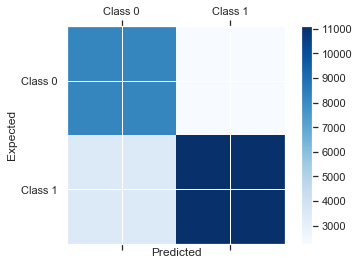

In [67]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [68]:
accText = 'Logistic Regression, Undersampling'

In [69]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 77.13%
 Precision: 83.10%
    Recall: 76.26%
  F1 score: 79.53%
 ROC score: 77.31%


In [70]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

##### KNN Classifier

In [71]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 20, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_under_tfidf, y_under_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 19


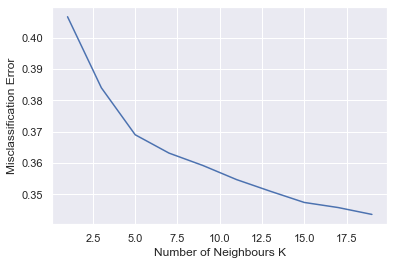

In [72]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [73]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 19, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
prediction = knn_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 5040  5386]
 [ 1760 12794]]


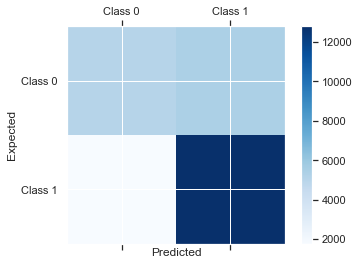

In [74]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=prediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [75]:
accText = 'KNN, Undersampling'

In [76]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 77.13%
 Precision: 83.10%
    Recall: 76.26%
  F1 score: 79.53%
 ROC score: 77.31%


In [77]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

##### SVM Classifier

In [78]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = svm_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 7817  2609]
 [ 3578 10976]]


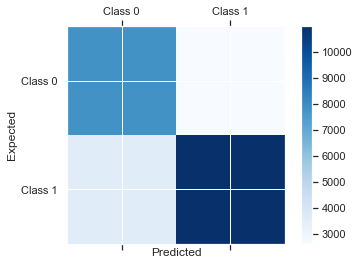

In [79]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [80]:
accText = 'SVM, Undersampling'

In [81]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 75.23%
 Precision: 80.79%
    Recall: 75.42%
  F1 score: 78.01%
 ROC score: 75.20%


In [82]:
acc = pd.read_csv("penguinni_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("penguinni_accuracies.csv")

### End of Step 4a